# test 3


In [47]:
import re,os,glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statistics
from collections import defaultdict
import numpy as np
# re patterns
base_save_dir="results/throughput/"
base_save_dir_thesis="../latex/results/"
base_dir=os.path.join("data/throughput/last")

file_pattern= r'(\w+)_(\w+)_tT(\d+)_(\d+).data'
matching_files = glob.glob(f"{base_dir}/*")

pub_pattern = r'cycles: (\d+) instruction: (\d+) start_ns: (\d+) end_ns: (\d+) start_s: (\d+) end_s: (\d+)'
sub_pattern = r'(\d+) received_s: (\d+) received_ns: (\d+)'

protocols=["udp","udpM","shm","tcp"]
sequence=[1,5,10,15,20,25,30,35,40]

# Calculate the IQR
def calculate_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

def timespec_difference(start_s, start_ns, end_s, end_ns):
    time1_merged= start_s *1e6 + start_ns / 1e3
    time2_merged= end_s *1e6 + end_ns / 1e3
    return (time2_merged - time1_merged)




## Retrive data

In [48]:
sent_data={}
received_negative={}
received_data={}
sent_data_time={}
for prot in protocols:
    sent_data[prot]={}
    received_data[prot]={}
    sent_data_time[prot]={}
    for seq in sequence:
        sent_data[prot][seq]=[]
        received_data[prot][seq]=[]
        sent_data_time[prot][seq]=[]

for files in matching_files:
    match_file = re.search(file_pattern, files)
    if match_file:
        actor,protocol,testN,subIndex = match_file.groups()
        if actor == "pub": #pubs
            with open(files, 'r') as file: 
                for line in file:
                    match = re.search(pub_pattern, line)
                    if match:
                        cycles, instruction, start_ns, end_ns, start_s, end_s = match.groups()
                        sent_data[protocol][int(testN)].append((int(cycles), int(instruction), int(start_s), int(start_ns), int(end_s), int(end_ns)))
                        diff = timespec_difference(int(start_s), int(start_ns) , int(end_s) ,int(end_ns) )
                        sent_data_time[protocol][int(testN)].append(diff)
                    else: print("NOT MATCH PUB")
        else: # subs
            with open(files, 'r') as file: 
                for content in file:
                    match = re.search(sub_pattern, content)
                    if match:
                        line_n, received_s, received_ns = match.groups()
                        start_s,start_ns = ((sent_data[protocol][int(testN)][int(line_n)][2], sent_data[protocol][int(testN)][int(line_n)][3]))
                        diff = timespec_difference(start_s, start_ns , int(received_s), int(received_ns)) / 2
                        received_data[protocol][int(testN)].append(diff)


### Cleaning data

In [49]:
column_time_avg ={}
column_time_cleaned = {}
column_timesent_avg ={}
column_timesent_cleaned = {}
for prots in protocols:
    column_time_cleaned[prots]={}
    column_time_avg[prots]={}
    column_timesent_cleaned[prots]={}
    column_timesent_avg[prots]={}
    for seq in sequence:
        try:
            lower_bound, upper_bound = calculate_iqr(received_data[prots][seq])
            column_time_cleaned[prots][seq] = [x for x in received_data[prots][seq] if lower_bound <= x <= upper_bound]
            column_time_avg[prots][seq]=np.average(column_time_cleaned[prots][seq])
            #print(column_time_avg[prots][seq])
        except: pass
    for seq in sequence:
        try:
            lower_bound, upper_bound = calculate_iqr(sent_data_time[prots][seq])
            column_timesent_cleaned[prots][seq] = [x for x in sent_data_time[prots][seq] if lower_bound <= x <= upper_bound]
            column_timesent_avg[prots][seq]=np.average(column_timesent_cleaned[prots][seq])
            #print(column_time_avg[prots][seq])
        except: pass


# Sending-receive

### Sequence 1: only 1 pub 1 sub

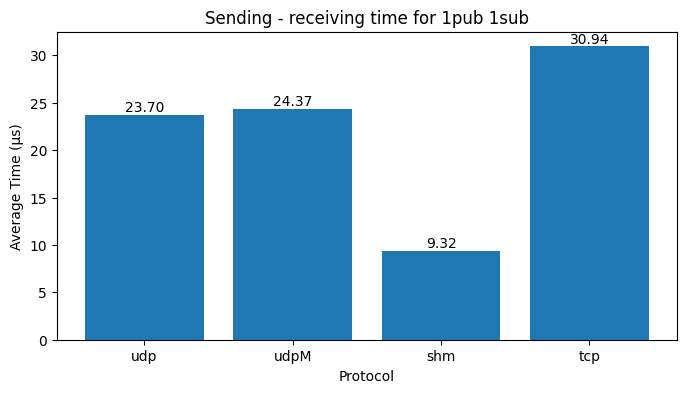

In [50]:
sequence_to_compare = 1
data_to_compare = {prots: column_time_cleaned[prots][sequence_to_compare] for prots in protocols}

average_times = [np.mean(data_to_compare[prots]) for prots in protocols]

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
bars = ax.bar(protocols, average_times)

for bar, value in zip(bars, average_times):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{value:.2f}', ha='center', va='bottom')

ax.set_xlabel('Protocol')
ax.set_ylabel('Average Time (μs)')
plt.savefig(f"{base_save_dir_thesis}test3_bar_sr_1p1s.png")
ax.set_title(f'Sending - receiving time for 1pub 1sub')
plt.savefig(f"{base_save_dir}test3_bar_sr_1p1s.png")


plt.show()


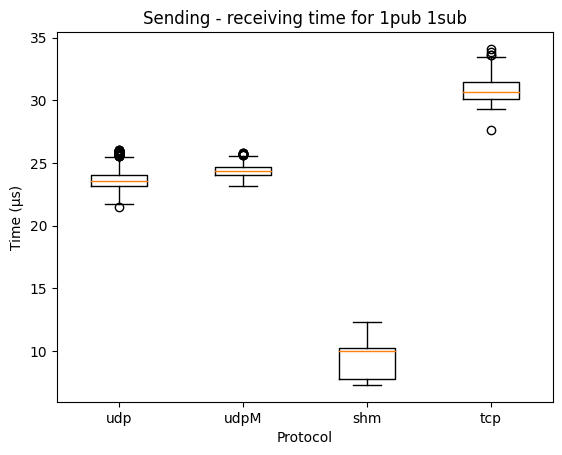

In [51]:
data_to_compare = {prots: column_time_cleaned[prots][sequence_to_compare] for prots in protocols}

data_list = [data_to_compare[prots] for prots in protocols]

fig, ax = plt.subplots()

ax.boxplot(data_list, labels=protocols)
ax.set_xlabel('Protocol')
ax.set_ylabel('Time (μs)')
ax.set_title(f'Sending - receiving time for 1pub 1sub')
plt.show()



### All sequence

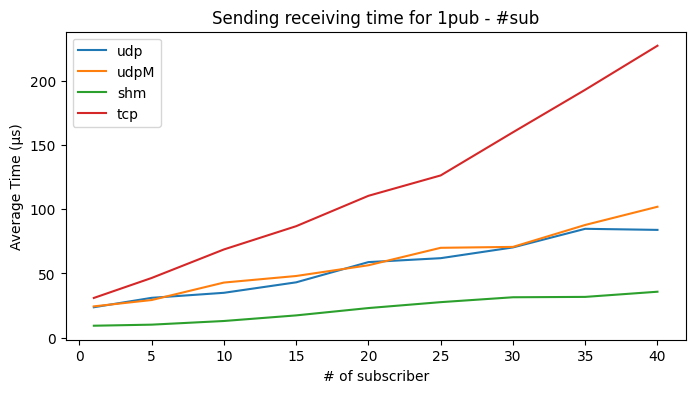

In [52]:
avg_data = {prots: [column_time_avg[prots][seq] for seq in sequence] for prots in protocols}

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)

for prots in protocols:
    ax.plot(sequence, avg_data[prots], label=prots)
ax.set_xlabel('# of subscriber')
ax.set_ylabel('Average Time (μs)')
ax.legend()
plt.savefig(f"{base_save_dir_thesis}test3_sendingreceiving_multiplesub.png")
ax.set_title('Sending receiving time for 1pub - #sub')
plt.savefig(f"{base_save_dir}test3_sendingreceiving_multiplesub.png")


plt.show()

### udp vs udpM

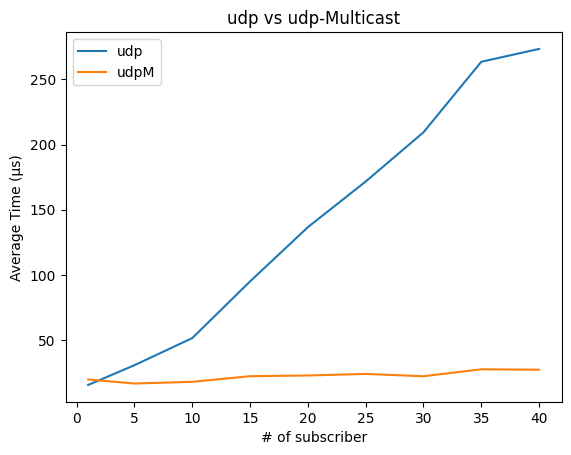

In [53]:
avg_data = {prots: [column_timesent_avg[prots][seq] for seq in sequence] for prots in ["udp","udpM"]}

fig, ax = plt.subplots()
for prots in ["udp","udpM"]:
    ax.plot(sequence, avg_data[prots], label=prots)
ax.set_xlabel('# of subscriber')
ax.set_ylabel('Average Time (μs)')
ax.legend()
plt.savefig(f"{base_save_dir_thesis}test3_udpvsudpM.png")

ax.set_title('udp vs udp-Multicast')
plt.savefig(f"{base_save_dir}test3_udpvsudpM.png")



plt.show()

# Only send


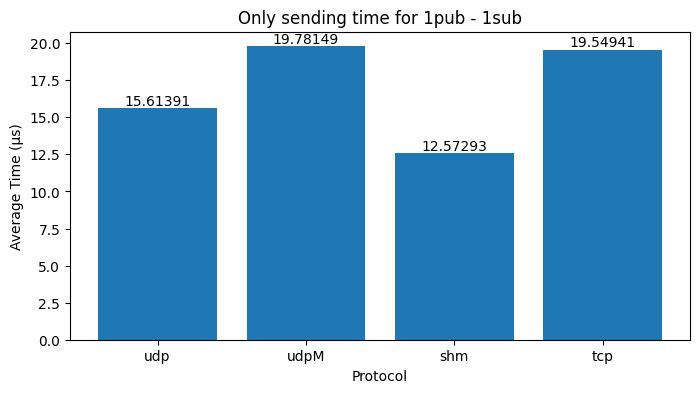

In [54]:
sequence_to_compare = 1
data_to_compare = {prots: column_timesent_cleaned[prots][sequence_to_compare] for prots in protocols}

average_times = [np.mean(data_to_compare[prots]) for prots in protocols]

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
bars = ax.bar(protocols, average_times)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.5f}', ha='center', va='bottom')

ax.set_xlabel('Protocol')
ax.set_ylabel('Average Time (μs)')
plt.savefig(f"{base_save_dir_thesis}test3_sending_1sub.png")
ax.set_title(f'Only sending time for 1pub - 1sub')
plt.savefig(f"{base_save_dir}test3_sending_1sub.png")



plt.show()

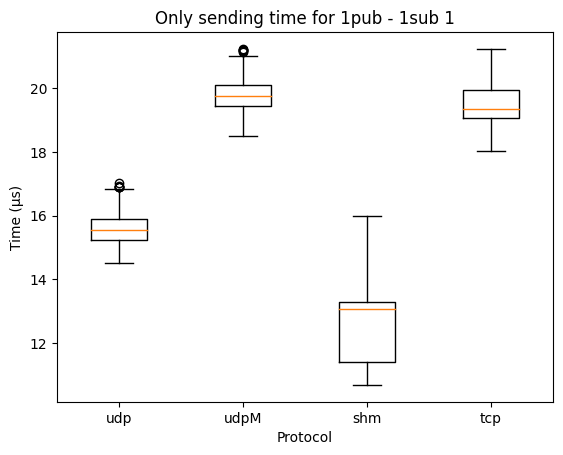

In [55]:
data_to_compare = {prots: column_timesent_cleaned[prots][sequence_to_compare] for prots in protocols}

data_list = [data_to_compare[prots] for prots in protocols]

fig, ax = plt.subplots()

ax.boxplot(data_list, labels=protocols)
ax.set_xlabel('Protocol')
ax.set_ylabel('Time (μs)')
ax.set_title(f'Only sending time for 1pub - 1sub {sequence_to_compare}')
plt.show()        

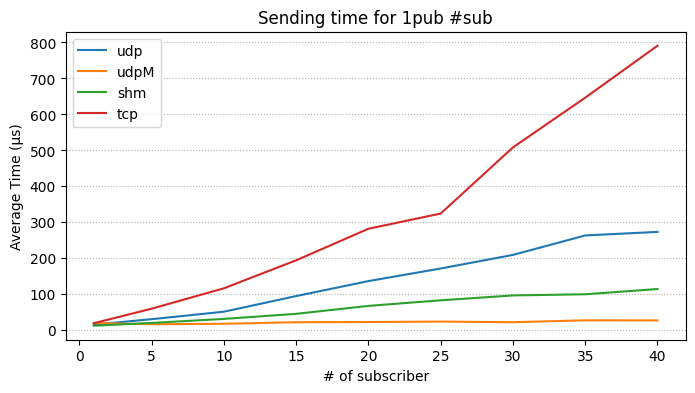

In [56]:
avg_data = {prots: [column_timesent_avg[prots][seq] for seq in sequence] for prots in protocols}

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
for prots in protocols:
    ax.plot(sequence, avg_data[prots], label=prots)
ax.set_xlabel('# of subscriber')
ax.set_ylabel('Average Time (μs)')
ax.legend()
plt.grid(axis='y', linestyle=':')
plt.savefig(f"{base_save_dir_thesis}test3_sending_multiplesub.png")
ax.set_title('Sending time for 1pub #sub')
plt.savefig(f"{base_save_dir}test3_sending_multiplesub.png")



plt.show()

# Protocol in-depth analysis

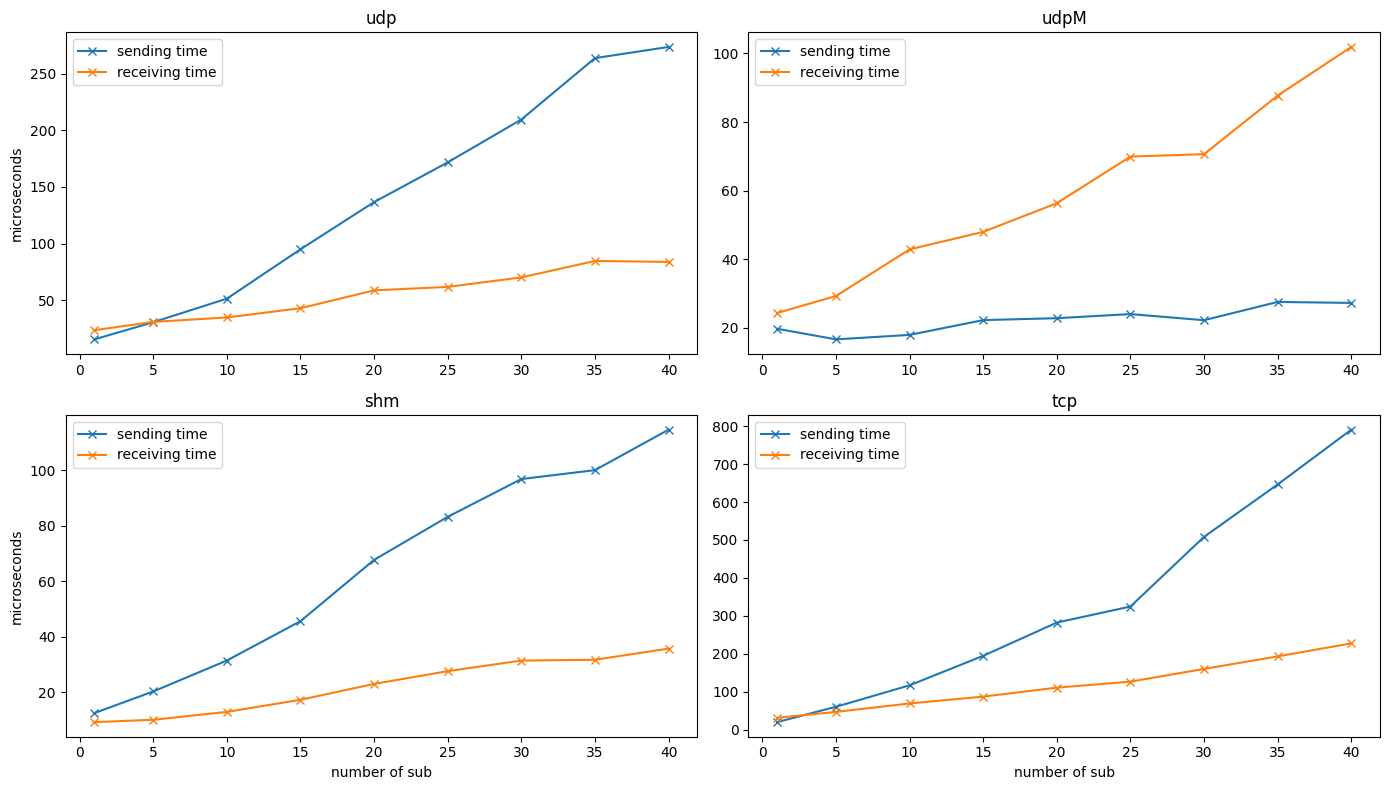

In [57]:
sent_avg={}
time_avg={}

for prot in protocols:
    sent_avg[prot] = [column_timesent_avg[prot][seq] for seq in sequence]
    time_avg[prot] = [column_time_avg[prot][seq] for seq in sequence]

fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2)
for i,prot in enumerate(protocols):
    ax = plt.subplot(gs[i])
    ax.set_title(prot)
    ax.plot(sequence, sent_avg[prot], label='sending time', marker='x')
    ax.plot(sequence, time_avg[prot], label='receiving time', marker='x')
    if(i==2 or i== 3): ax.set_xlabel('number of sub')
    if(prot== "shm" or prot == "udp"): ax.set_ylabel('microseconds')
    ax.legend()

plt.savefig(f"{base_save_dir}test3_different_protocol_send_receive.png")
plt.savefig(f"{base_save_dir_thesis}test3_different_protocol_send_receive.png")


plt.tight_layout()
plt.show()

# Troughput

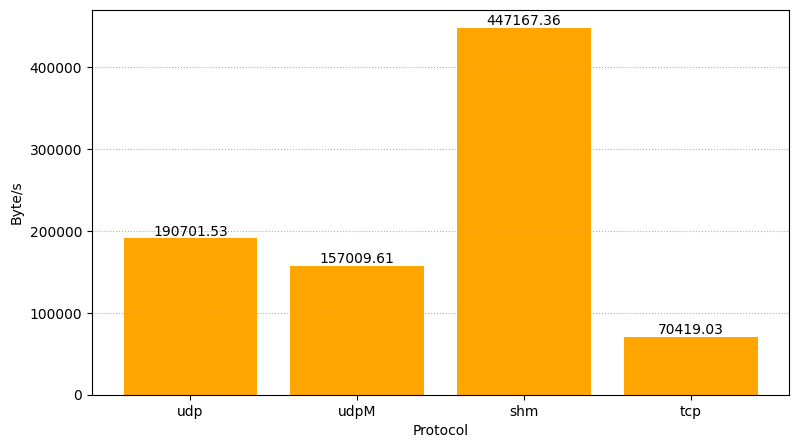

In [96]:
throughput_send={}
throughput_receive={}
for prot in protocols:
    throughput_send[prot]=      1/column_timesent_avg[prot][40] * 1e6 * 1 * 16 # it was on microseconds but witk K
    throughput_receive[prot] =  1/column_time_avg[prot][40] * 1e6 * 1 * 16 # it was on microseconds but with K

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot()
ax.set_xlabel('Protocol')
ax.set_ylabel('Byte/s')

data_to_compare = {prots: throughput_receive[prots] for prots in protocols}
average_times = [np.mean(data_to_compare[prots]) for prots in protocols] 
bars = ax.bar(protocols, average_times,color="orange")
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
plt.grid(axis='y', linestyle=':')
plt.savefig(f"{base_save_dir_thesis}test3_throughput.png")
#ax.set_title(f'Sending Throughput')
plt.savefig(f"{base_save_dir}test3_throughput.png")


plt.show()

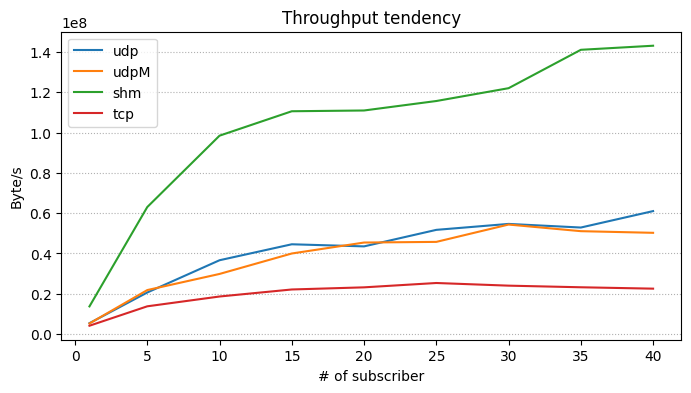

In [59]:
avg_data = {prots: [ 1 / column_time_avg[prots][seq] * 1e6 * seq * 16 * 8 for seq in sequence] for prots in protocols}

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
for prots in protocols:
    ax.plot(sequence, avg_data[prots], label=prots)
ax.set_xlabel('# of subscriber')
ax.set_ylabel('Byte/s')
ax.legend()
plt.grid(axis='y', linestyle=':')
plt.savefig(f"{base_save_dir_thesis}test3_graph_throughput.png")
ax.set_title('Throughput tendency')
plt.savefig(f"{base_save_dir}test3_graph_throughput.png")


## Instruction vs TSC

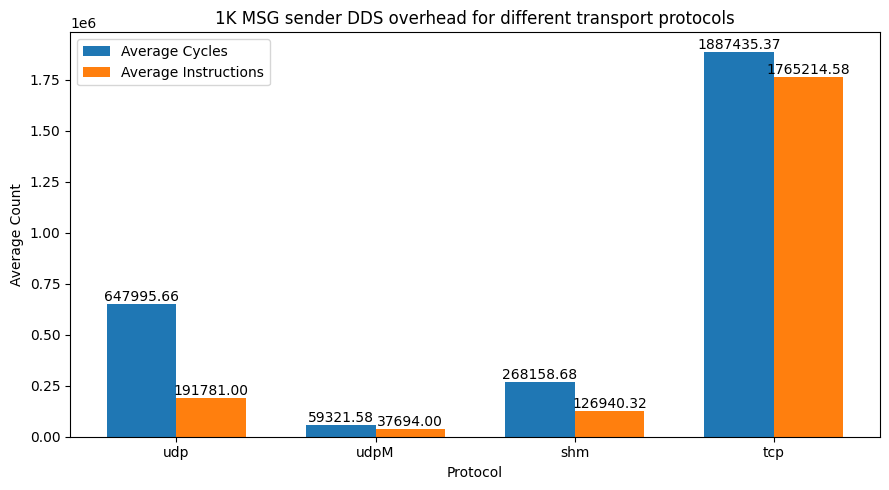

In [99]:
cycles,cycles_cleaned,instructions_cleaned={},{},{}
instructions={}
average_cycles={}
average_instructions={}

for prot in protocols:
    cycles[prot] = [data[0] for data in sent_data[prot][40]]
    instructions[prot] = [data[1] for data in sent_data[prot][40]]
    lower_bound, upper_bound = calculate_iqr(cycles[prot])
    cycles_cleaned[prot] = [x for x in cycles[prot] if lower_bound <= x <= upper_bound]
    lower_bound, upper_bound = calculate_iqr(instructions[prot])
    instructions_cleaned[prot] = [x for x in instructions[prot] if lower_bound <= x <= upper_bound]
    average_cycles[prot] = sum(cycles_cleaned[prot]) / len(cycles_cleaned[prot])
    average_instructions[prot] = sum(instructions_cleaned[prot]) / len(instructions_cleaned[prot])

fig, ax = plt.subplots(figsize=(9, 5))
bar_width = 0.35
x = range(len(protocols))
barsc = plt.bar(x, average_cycles.values(), width=bar_width, label='Average Cycles')
barsi=plt.bar([i + bar_width for i in x], average_instructions.values(), width=bar_width, label='Average Instructions')
plt.xticks([i + bar_width / 2 for i in x], protocols)
plt.xlabel('Protocol')
plt.ylabel('Average Count')
for bar in barsc:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
for bar in barsi:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
plt.title("Average cycles and instruction vs different protocols")
plt.legend()
plt.tight_layout()

plt.savefig(f"{base_save_dir_thesis}test1_cyclinstr.png")
ax.set_title(f'Average MSG sender DDS overhead for different transport protocols')
plt.savefig(f"{base_save_dir}test1_cyclinstr.png")

#Label: numero di cicli e istruzioni necessari per inviare 1 messaggio in diversi protcolli. 
plt.show()

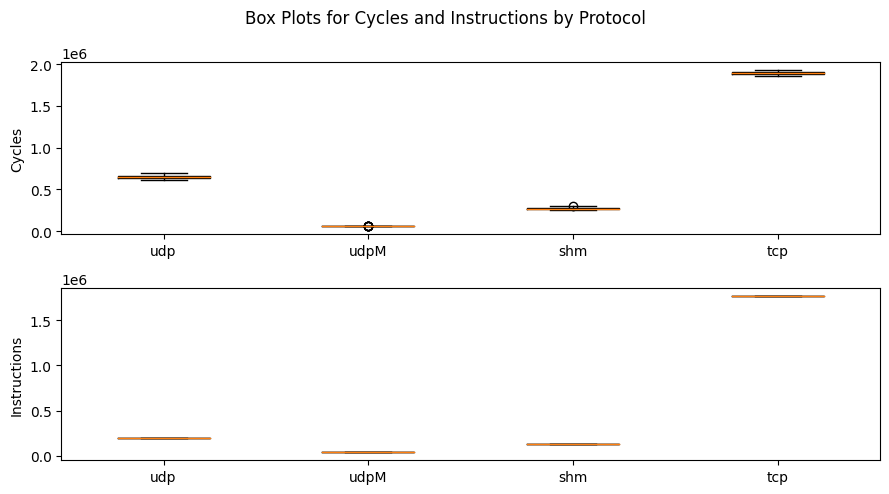

In [61]:
fig, axs = plt.subplots(2, figsize=(9, 5))
fig.suptitle('Box Plots for Cycles and Instructions by Protocol')

# Box plot for cycles
axs[0].boxplot(cycles_cleaned.values())
axs[0].set_xticklabels(cycles_cleaned.keys())
axs[0].set_ylabel('Cycles')

# Box plot for instructions
axs[1].boxplot(instructions_cleaned.values())
axs[1].set_xticklabels(instructions_cleaned.keys())
axs[1].set_ylabel('Instructions')

plt.tight_layout()
plt.show()


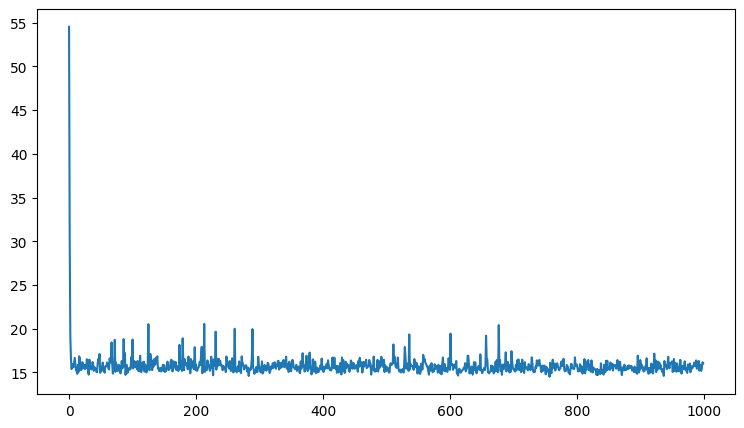

In [92]:
fig, ax = plt.subplots( figsize=(9, 5))
avg_data = {prots: [sent_data_time[prots][seq] for seq in [5]] for prots in ["udp"]}

plt.plot(sent_data_time["udp"][1])